In [50]:
# import pandas as pd
# import cryptpandas as crp

# decrypted_df = crp.read_encrypted(path='encrypted_data/release_3547.crypt', password='oUFtGMsMEEyPCCP6')

# decrypted_df.to_csv('decrypted_data/release_3547.csv')

In [51]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

# Load data from CSV format into a DataFrame (assuming the input is from a file or given as a string)
data = pd.read_csv('decrypted_data/release_3611.csv', index_col=0)

# Handle missing data by filling NaNs with 0 (or use another strategy as appropriate)
data.fillna(0, inplace=True)

# Split data into training and testing sets (80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Calculate mean returns and covariance matrix from training data
mean_returns = train_data.mean()
cov_matrix = train_data.cov()

# Define the MVO objective function (minimize negative Sharpe ratio)
def portfolio_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # We minimize negative Sharpe for maximization

# Set up constraints and bounds for optimization
num_assets = len(mean_returns)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling

# Initial guess for weights
initial_weights = np.array([1/num_assets] * num_assets)

# Optimize portfolio weights using MVO
optimized_result = minimize(portfolio_sharpe, initial_weights, args=(mean_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal weights
optimal_weights = optimized_result.x

# Evaluate portfolio on the test set
test_portfolio_return = np.dot(optimal_weights, test_data.mean())
test_portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(test_data.cov(), optimal_weights)))
test_sharpe_ratio = test_portfolio_return / test_portfolio_volatility  # Assuming risk-free rate is 0

# Print results
print("Optimal Weights:", optimal_weights)
print("Test Portfolio Return:", test_portfolio_return)
print("Test Portfolio Volatility:", test_portfolio_volatility)
print("Test Sharpe Ratio:", test_sharpe_ratio)


Optimal Weights: [2.52038598e-03 0.00000000e+00 1.24646816e-02 0.00000000e+00
 1.91639974e-01 3.26886955e-17 9.88153067e-03 0.00000000e+00
 1.49281087e-17 5.41597682e-03 0.00000000e+00 2.85687272e-17
 3.08006771e-02 1.40511587e-04 0.00000000e+00 1.53143557e-18
 0.00000000e+00 6.74351408e-02 1.71850950e-01 1.77317640e-02
 0.00000000e+00 2.89044751e-01 2.01073656e-01]
Test Portfolio Return: 0.05175467294471778
Test Portfolio Volatility: 0.444962627912008
Test Sharpe Ratio: 0.11631240400475236


In [52]:
# Number of strategies
num_strategies = data.shape[1]

# Equal weights
equal_weights = np.array([1/num_strategies] * num_strategies)

# Print equal weights
print("Equal Weights:", equal_weights)

# Portfolio return and volatility on the test set
equal_portfolio_return = np.dot(equal_weights, test_data.mean())
equal_portfolio_volatility = np.sqrt(np.dot(equal_weights.T, np.dot(test_data.cov(), equal_weights)))
equal_sharpe_ratio = equal_portfolio_return / equal_portfolio_volatility

print("Equal Weight Portfolio Return:", equal_portfolio_return)
print("Equal Weight Portfolio Volatility:", equal_portfolio_volatility)
print("Equal Weight Portfolio Sharpe Ratio:", equal_sharpe_ratio)


Equal Weights: [0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826]
Equal Weight Portfolio Return: 0.016229847921347827
Equal Weight Portfolio Volatility: 0.3151124580518201
Equal Weight Portfolio Sharpe Ratio: 0.05150493897222824


In [53]:
# Function to calculate risk contributions
def calculate_risk_contribution(weights, cov_matrix):
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_contrib = np.dot(cov_matrix, weights) / portfolio_volatility
    risk_contrib = weights * marginal_contrib
    return risk_contrib / portfolio_volatility

# Objective function for risk-parity (minimize differences in risk contributions)
def risk_parity_objective(weights, cov_matrix):
    risk_contrib = calculate_risk_contribution(weights, cov_matrix)
    target_contrib = np.ones_like(risk_contrib) / len(risk_contrib)
    return np.sum((risk_contrib - target_contrib)**2)

# Initial weights and bounds
initial_weights = np.array([1/num_assets] * num_assets)

# Optimize for risk parity
risk_parity_result = minimize(risk_parity_objective, initial_weights, args=(cov_matrix),
                              method='SLSQP', bounds=bounds, constraints=constraints)
risk_parity_weights = risk_parity_result.x

# Print risk-parity results
print("Risk Parity Weights:", risk_parity_weights)

# Portfolio return and volatility on the test set
risk_parity_portfolio_return = np.dot(risk_parity_weights, test_data.mean())
risk_parity_portfolio_volatility = np.sqrt(np.dot(risk_parity_weights.T, np.dot(test_data.cov(), risk_parity_weights)))
risk_parity_sharpe_ratio = risk_parity_portfolio_return / risk_parity_portfolio_volatility

print("Risk Parity Portfolio Return:", risk_parity_portfolio_return)
print("Risk Parity Portfolio Volatility:", risk_parity_portfolio_volatility)
print("Risk Parity Portfolio Sharpe Ratio:", risk_parity_sharpe_ratio)


Risk Parity Weights: [0.01892415 0.02804613 0.03558419 0.0243967  0.07399436 0.02295322
 0.02963682 0.02375617 0.03270298 0.02304525 0.0795     0.02789771
 0.04434214 0.05415809 0.03639498 0.02185792 0.02573358 0.02685891
 0.08009312 0.03988267 0.08812325 0.02888945 0.13322818]
Risk Parity Portfolio Return: 0.007786720463204457
Risk Parity Portfolio Volatility: 0.2323566131475278
Risk Parity Portfolio Sharpe Ratio: 0.0335119382130971


In [54]:
import pandas as pd
import numpy as np

# Load data
data_path = 'decrypted_data/release_3547.csv'  # Replace with your actual path
data = pd.read_csv(data_path, index_col=0)

# Fill missing values with 0 (or you could use data.fillna(method='ffill') for forward filling)
data.fillna(0, inplace=True)

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    mean_return = returns.mean()
    return_std = returns.std()
    if return_std == 0:
        return np.nan  # Avoid division by zero
    sharpe_ratio = (mean_return - risk_free_rate) / return_std
    return sharpe_ratio

# Calculate Sharpe ratio for each strategy
sharpe_ratios = data.apply(calculate_sharpe_ratio, axis=0)

# Display the Sharpe ratios
print("Sharpe Ratios for each strategy:")
print(sharpe_ratios)


Sharpe Ratios for each strategy:
strat_0     0.020420
strat_1    -0.085913
strat_2     0.007062
strat_3     0.056840
strat_4     0.074996
strat_5     0.028912
strat_6     0.027356
strat_7     0.039360
strat_8     0.030450
strat_9     0.006175
strat_10   -0.076086
strat_11    0.012910
strat_12    0.020245
strat_13   -0.054725
strat_14   -0.014595
strat_15    0.005406
strat_16    0.005928
strat_17    0.032691
strat_18   -0.012786
strat_19    0.042504
strat_20   -0.017792
strat_21    0.093788
dtype: float64


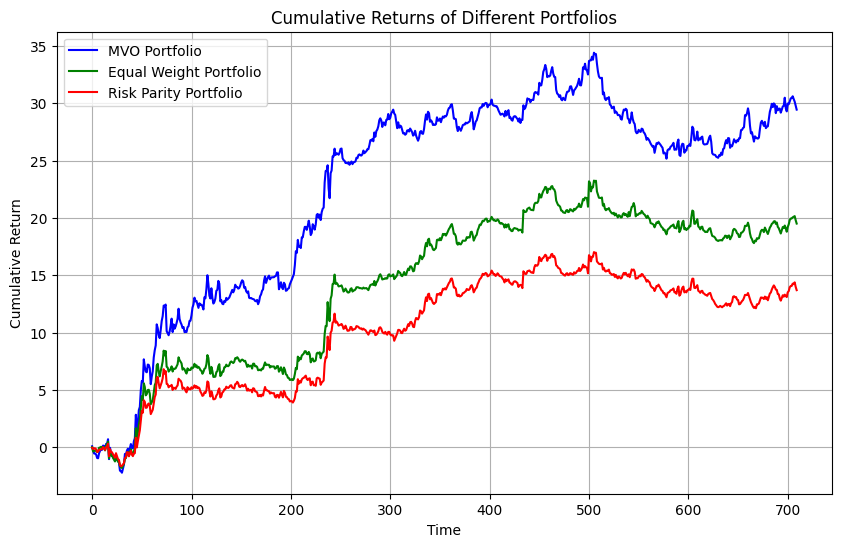

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming `data` is the DataFrame containing the asset returns for your strategies
# (from your provided data format)

# Number of strategies (assets) and data points
num_strategies = data.shape[1]  # 22 strategies
returns_data = data.values  # Assuming `data` is your return data

# Train-Test split (e.g., 80% train, 20% test)
train_size = int(0.8 * len(returns_data))
train_data = returns_data[:train_size, :]
test_data = returns_data[train_size:, :]

# 1. Mean-Variance Optimization (MVO) with max weight constraint of 0.1
mean_returns = train_data.mean(axis=0)
cov_matrix = np.cov(train_data.T)

# MVO function and constraints
def portfolio_sharpe(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility  # Negative for minimization

# Constraints and bounds
bounds = tuple((0, 0.1) for _ in range(num_strategies))  # Set each weight to be between 0 and 0.1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Ensure sum of weights = 1

# Initial guess (equal weighting)
initial_weights = np.array([1/num_strategies] * num_strategies)

# Optimize MVO weights
optimized_result = minimize(portfolio_sharpe, initial_weights, args=(mean_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)
mvo_weights = optimized_result.x

# Portfolio returns using MVO weights
mvo_returns = np.dot(test_data, mvo_weights)

# 2. Equal Weighting with max weight constraint of 0.1
equal_weights = np.minimum(np.array([1/num_strategies] * num_strategies), 0.1)
equal_weights /= equal_weights.sum()  # Normalize to sum to 1
equal_returns = np.dot(test_data, equal_weights)

# 3. Risk-Parity with max weight constraint of 0.1
def calculate_risk_contribution(weights, cov_matrix):
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_contrib = np.dot(cov_matrix, weights) / portfolio_volatility
    risk_contrib = weights * marginal_contrib
    return risk_contrib / portfolio_volatility

def risk_parity_objective(weights, cov_matrix):
    risk_contrib = calculate_risk_contribution(weights, cov_matrix)
    target_contrib = np.ones_like(risk_contrib) / len(risk_contrib)
    return np.sum((risk_contrib - target_contrib)**2)

# Optimize Risk Parity weights
risk_parity_result = minimize(risk_parity_objective, initial_weights, args=(cov_matrix),
                              method='SLSQP', bounds=bounds, constraints=constraints)
risk_parity_weights = risk_parity_result.x

# Portfolio returns using Risk Parity weights
risk_parity_returns = np.dot(test_data, risk_parity_weights)

# Calculate cumulative returns
cumulative_mvo = np.cumsum(mvo_returns)
cumulative_equal = np.cumsum(equal_returns)
cumulative_risk_parity = np.cumsum(risk_parity_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_mvo, label="MVO Portfolio", color='blue')
plt.plot(cumulative_equal, label="Equal Weight Portfolio", color='green')
plt.plot(cumulative_risk_parity, label="Risk Parity Portfolio", color='red')

plt.title("Cumulative Returns of Different Portfolios")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Assuming `mvo_weights`, `equal_weights`, and `risk_parity_weights` have been computed as shown in previous steps

# Prepare the result in the desired format for each portfolio
result_mvo = {f'strat_{i}': weight for i, weight in enumerate(mvo_weights)}
result_equal = {f'strat_{i}': weight for i, weight in enumerate(equal_weights)}
result_risk_parity = {f'strat_{i}': weight for i, weight in enumerate(risk_parity_weights)}

# Add team name and passcode to the results
team_name = 'Longer Term Capital Management'
passcode = 'DogCat'

result_mvo['team_name'] = team_name
result_mvo['passcode'] = passcode

result_equal['team_name'] = team_name
result_equal['passcode'] = passcode

result_risk_parity['team_name'] = team_name
result_risk_parity['passcode'] = passcode

# Print the results in the specified format
print("MVO Portfolio Weights:")
print(result_mvo)

print("\nEqual-Weight Portfolio Weights:")
print(result_equal)

print("\nRisk-Parity Portfolio Weights:")
print(result_risk_parity)


MVO Portfolio Weights:
{'strat_0': 0.07233390860282651, 'strat_1': 0.0, 'strat_2': 0.07078687569048586, 'strat_3': 0.09999999999999999, 'strat_4': 0.09999999999999999, 'strat_5': 2.5844669286623212e-17, 'strat_6': 0.09999999999999998, 'strat_7': 6.057979638762756e-18, 'strat_8': 0.06543481433138472, 'strat_9': 2.108773225484306e-17, 'strat_10': 8.321251673826247e-18, 'strat_11': 0.042563755941326574, 'strat_12': 0.1, 'strat_13': 0.0, 'strat_14': 4.363913744254155e-18, 'strat_15': 0.0, 'strat_16': 0.0, 'strat_17': 0.09999999999999999, 'strat_18': 0.08945682513477668, 'strat_19': 0.059423820299199605, 'strat_20': 0.0, 'strat_21': 0.1, 'team_name': 'Longer Term Capital Management', 'passcode': 'DogCat'}

Equal-Weight Portfolio Weights:
{'strat_0': 0.04545454545454546, 'strat_1': 0.04545454545454546, 'strat_2': 0.04545454545454546, 'strat_3': 0.04545454545454546, 'strat_4': 0.04545454545454546, 'strat_5': 0.04545454545454546, 'strat_6': 0.04545454545454546, 'strat_7': 0.04545454545454546, 

<Axes: >

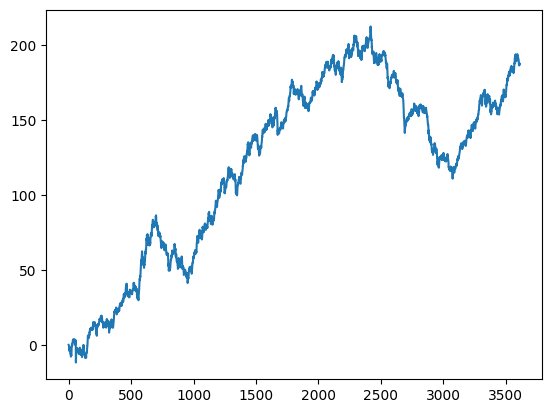

In [ ]:
import pandas as pd
import numpy as np

# Define the strategy weights
weights = {
    'strat_0': -0.007922,
    'strat_1': -0.100000,
    'strat_2': -0.015617,
    'strat_3': 0.011628,
    'strat_4': 0.053937,
    'strat_5': -0.005840,
    'strat_6': 0.026254,
    'strat_7': 0.074277,
    'strat_8': -0.033935,
    'strat_9': 0.026118,
    'strat_10': -0.100000,
    'strat_11': -0.028654,
    'strat_12': 0.009007,
    'strat_13': 0.062587,
    'strat_14': -0.035835,
    'strat_15': 0.008440,
    'strat_16': -0.001206,
    'strat_17': 0.052603,
    'strat_18': 0.075149,
    'strat_19': -0.070992,
    'strat_20': -0.100000,
    'strat_21': 0.100000
}

df = pd.read_csv('decrypted_data/release_3611.csv')  # Update the file path as needed
df = df.drop(['Unnamed: 0'], axis=  1)

for strat, weight in weights.items():
    if strat in df.columns:
        df[strat] = df[strat] * weight

df['row_sum'] = df.sum(axis=1)


df['row_sum'].cumsum().plot()
